In [140]:
from tqdm import tqdm
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from SNIPRQ import StemGroups, QuadPaths
from IPython.display import clear_output
import networkx as nx
from itertools import combinations_with_replacement
from scipy.stats import mannwhitneyu
from ipyparallel import Client

plt.style.use('fivethirtyeight')
def clean_axis(ax):
    ax.xaxis.set_tick_params(labelsize=11)
    ax.yaxis.set_tick_params(labelsize=11)
    for i in ['top', 'bottom', 'left', 'right']:
        ax.spines[i].set_visible(False)
    ax.grid(which='major', linestyle='--', alpha=0.5)
    return True

DVIEW = Client()[:]
DVIEW.block=True
len(DVIEW)

30

In [ ]:
# Will take around 2 hours to run

from ipyparallel import Client
DVIEW = Client()[:]
DVIEW.block=True
len(DVIEW)

def get_sam_line(bed_line):
    c = bed_line.rstrip('\n').split('\t')
    sam_dir = '/home/parashar/scratch/quadcomb/data/g4_seq/reanalysis/aligned_sequences'
    sub_dirs = ['Na_K_1/SRR1693705', 'Na_K_1/SRR1693706']
    for sd in sub_dirs:
        read_name = c[3]
        flag = '0' if c[5] == '+' else '16'
        fn = sd.split('/')[-1][-2:] + '_' + str(int(int(read_name)/1e6)) + '.sam'
        fn_path = "%s/%s/%s" % (sam_dir, sd, fn)
        grep_res = !grep $read_name $fn_path
        for res in grep_res:
            sam_line = res.split('\t')
            if len(sam_line) in [19, 20]:
                aligned_pos = int(sam_line[3]) - 1
                change_point_pos = int(c[1])
                if sam_line[0].split('.')[1] == read_name:
                    if sam_line[2] == c[0]:
                        if aligned_pos+150 > change_point_pos > aligned_pos:
                            if sam_line[1] == flag:
                                c[3] = sam_line[0]
                                c[4] = str(aligned_pos)
                                c.append(sam_line[9])
                                return c
    return ['False']

changepoint_bed = '../data/oq_switchpoints/Na_K_1_unique.bed'
bed_data = []
sam_data = []
with open(changepoint_bed) as h:
    for l in tqdm(h):
        bed_data.append(l)
        if len(bed_data) == 300:
            sam_data.extend(DVIEW.map_sync(get_sam_line, bed_data))
            bed_data = []
sam_data.extend(DVIEW.map_sync(get_sam_line, bed_data))
with open('../data/oq_switchpoints/Na_K_1_unique_with_sam_data.bed', 'w') as OUT:
    OUT.write('\n'.join(['\t'.join(x) for x in sam_data]))

In [2]:
def comp(s):
    nuc_map = {'A':'T', 'T':'A', 'G':'C', 'C':'G', 'N': 'N'}
    return ''.join([nuc_map[i.upper()] for i in s])

oq_sequences = []
change_point_positions = []
with open('../data/oq_switchpoints/Na_K_1_unique_with_sam_data.bed') as h:
    for n,l in enumerate(h):
        print ('\r%d' % n, end='')
        c = l.rstrip('\n').split('\t')
        p = int(c[1]) - int(c[4])
        s = c[6]
        if c[5] == '-':
            s = s[::-1]
            # -1 considering a previous offset issue upstream
            p = (len(s)-p-1)
            oq_sequences.append(s) 
            change_point_positions.append(p)
        if c[5] == "+":
            s = comp(s)
            oq_sequences.append(s) 
            change_point_positions.append(p)
clear_output()

In [3]:
base_comp = np.array([[0, 0, 0, 0] for x in range(51)])
nuc_idx = {'A': 0, 'T': 1, 'G': 2, 'C': 3}
for p,s in zip(change_point_positions, oq_sequences):
    ss = s[p-20:p+31]
    for i in range(51):
        if ss[i] == 'N':
            continue
        base_comp[i][nuc_idx[ss[i].upper()]] += 1

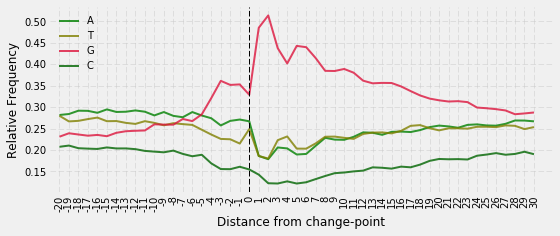

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))

for i,j,c in zip(base_comp.T, ['A', 'T', 'G', 'C'],
                 ['green', 'olive', 'crimson', 'darkgreen']):
    ax.plot(i/base_comp.sum(axis=1)[0], label=j, lw=2, c=c, alpha=0.8)
ax.axvline(20, lw=1, ls='--', c='k')
ax.set_xticks(range(51))
ax.set_xticklabels(range(-20, 31, 1), rotation=90)
ax.set_xlabel('Distance from change-point', fontsize=12)
ax.set_ylabel('Relative Frequency', fontsize=12)
ax.set_xlim((-1, 52))
ax.legend(fontsize=10, frameon=False, loc='upper left')
clean_axis(ax)
plt.tight_layout()
plt.savefig('../images/BasecompGSS.svg', transparent=True, edgecolor='none')
plt.show()

In [43]:
base_comp_ratio = []
for i in range(base_comp.shape[0]):
    base_comp_ratio.append(base_comp[i, :]/base_comp.sum(axis=1)[i])
base_comp_ratio = np.array(base_comp_ratio)
base_comp_ratio.shape

(51, 4)

In [40]:
base_comp.sum(axis=1)

array([83779, 83779, 83779, 83779, 83779, 83779, 83779, 83779, 83779,
       83779, 83779, 83779, 83761, 83777, 83760, 83759, 83776, 83778,
       83779, 83779, 83713, 83759, 83353, 82793, 80762, 80206, 80299,
       81406, 82386, 82577, 82826, 82700, 83119, 83437, 83069, 83269,
       83539, 83384, 83586, 83680, 83585, 83531, 83377, 83600, 83743,
       83640, 83616, 83746, 83731, 83661, 83606])

In [46]:
base_comp_ratio[:5, :]

array([[ 0.28166963,  0.27983146,  0.23102448,  0.20747443],
       [ 0.28394944,  0.26668974,  0.23902171,  0.21033911],
       [ 0.29168407,  0.26801466,  0.2361451 ,  0.20415617],
       [ 0.29132599,  0.27213263,  0.23337591,  0.20316547],
       [ 0.28677831,  0.27561799,  0.23517827,  0.20242543]])

In [45]:
base_comp_ratio[19:24, :]

array([[ 0.27105838,  0.21503002,  0.35301209,  0.16089951],
       [ 0.2671867 ,  0.2489458 ,  0.32911256,  0.15475494],
       [ 0.18612925,  0.18610537,  0.48523741,  0.14252797],
       [ 0.17945365,  0.18097729,  0.5165261 ,  0.12304296],
       [ 0.2083751 ,  0.22557463,  0.44277898,  0.12327129]])

In [23]:
base_comp.sum(axis=0)

array([1088958, 1046382, 1376493,  737383])

In [4]:
def stem_encoder(stem_array, graphStart):
    diff = np.diff(stem_array)
    if diff[0] != 1:
        return '%d%s**' % (stem_array[0] - graphStart, '-' * (diff[0] - 1))
    else:
        return '%d*%s*' % (stem_array[0] - graphStart, '-' * (diff[1] - 1))

def populate_graph(stems):
    G = nx.DiGraph()
    maxLoopLen = 25
    graphStart = stems[0][0]
    all_starts = stems[:, 0]
    nodeCodes = {}
    sortedNodes = []
    for stem in stems:
        targets = np.where((all_starts > stem[2] + 1) &
                 (all_starts <= stem[2] + maxLoopLen + 1))[0]
        n1 = stem_encoder(stem, graphStart)
        sortedNodes.append(n1)
        nodeCodes[n1] = stem
        for t in targets:
            n2 = stem_encoder(stems[t], graphStart)
            l = stems[t][0] - stem[2] - 1
            G.add_edge(n1, n2, attr_dict={'length':l})
    return nodeCodes, sortedNodes, G

pre_cp = []
mock_cp = []
on_cp = []
pre_cp_node_dist = {x:0 for x in range(0, 6)}
post_cp_node_dist = {x:0 for x in range(0, 6)}

for p,s in tqdm(zip(change_point_positions, oq_sequences),
                total=len(change_point_positions)):
    
    sg_obj = StemGroups(s, max_loop_len=25, max_bulge_len=5, base='G')
    for sg in sg_obj.generate_stems():
        node_codes, sorted_nodes, G = populate_graph(sg)
        for node in sorted_nodes:
            s1_len = node.count('-')
            node_span = list(range(node_codes[node][0], node_codes[node][2]))
            closest_nodes = {x: [26, None] for x in range(6)}
            if node not in G:
                continue
            for k,v in G[node].items():
                s2_len = k.count('-')
                if v['length'] < closest_nodes[s2_len][0]:
                    closest_nodes[s2_len][0] = v['length']
                    closest_nodes[s2_len][1] = k
            min_dist = min([closest_nodes[x][0] for x in range(6)])
            allowed_bulges = []
            for s2_len in closest_nodes:
                if closest_nodes[s2_len][0] <= min_dist+6:
                    allowed_bulges.append(s2_len)
            combinations = []
            for s2_len in closest_nodes:
                if closest_nodes[s2_len][1] is None or s2_len not in allowed_bulges:
                    continue
                combinations.append((min(s1_len, s2_len), closest_nodes[s2_len][0],
                               max(s1_len, s2_len)))
            if len(combinations) > 0:
                if node_codes[node][-1] < p:
                    pre_cp.extend(combinations)
                    pre_cp_node_dist[s1_len] += 1
                if 2*p > node_codes[node][0] >= p:
                    post_cp_node_dist[s1_len] += 1
                if p in node_span:
                    on_cp.extend(combinations)
                if p-5 in node_span:
                    mock_cp.extend(combinations)
pre_cp = np.array(pre_cp)
mock_cp = np.array(mock_cp)
on_cp = np.array(on_cp)
pre_cp.shape, mock_cp.shape, on_cp.shape

100%|██████████| 83779/83779 [07:54<00:00, 176.73it/s]


((670676, 3), (133553, 3), (197506, 3))

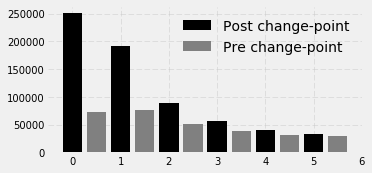

In [6]:
a = sum(pre_cp_node_dist.values())
b = sum(post_cp_node_dist.values())

fig, ax = plt.subplots(1, 1, figsize=(5,2.5))
for i in range(6):
    if i == 0:
        ax.bar([i], [post_cp_node_dist[i]], color='k',
           width=0.4, label='Post change-point')
        ax.bar([i+0.5], [pre_cp_node_dist[i]], color='grey',
           width=0.4, label='Pre change-point')
    else:
        ax.bar([i], [post_cp_node_dist[i]], color='k', width=0.4)
        ax.bar([i+0.5], [pre_cp_node_dist[i]], color='grey', width=0.4)
ax.set_yticks([x for x in range(0, 300000, 50000)])
ax.legend(frameon=False)
clean_axis(ax)
plt.savefig('../images/pre_post_cp_node_dist.svg', transparent=True, edgecolor='none')
plt.show()

In [148]:
def get_nodes(seq):
    import networkx as nx
    import numpy as np
    
    class StemGroups(object):
        """
            Searches for putative stems of G4. Identifies all stems of
            pattern GGG, GNGG or GGNG starting from each base of the
            sequence, where length of N can be upto max_bulge_len. This
            function only considers stems with one bulge. Also only three
            Gs will be considered as quartet forming Gs.

            Input parameters:
                sequence: A nucleotide sequence (type: str)
                max_bulge_len: Maximum length of a bulge allowed in stem
                               (type: int)
                max_loop_len: Maximum length of a loop. i.e distance
                              between two stems (type: int)
                base: Can be either 'G' or 'C' depending which strand to
                      search (type: str)
        """

        def __init__(self, sequence, max_loop_len, max_bulge_len, base):

            self.stems = []
            self.stemLen = 3  # QuadGraph supports stem length of 3 only.
            self.sequence = sequence.upper()
            self.base = base
            self.maxBulgeLen = max_bulge_len
            self.maxLoopLen = max_loop_len
            self.kmerSize = self.stemLen + self.maxBulgeLen
            self.stems = []
            self.pos = None
            self.kmer = None
            self.k_stems = None

        def generate_stems(self):
            """
                A generators that yields groups of stems such that,
                within a group the stems are guaranteed to form a
                G4 motif and also stems from different groups will not
                form a G4 motif given the maximum allowed loop length

                Yield value:
                    numpy array of shape s x 3, where s is the numnber of
                    stems found. For each stem sequence position of each G
                    within the stem is indicated.
            """

            for i in range(len(self.sequence) - self.kmerSize + 1):
                self.pos = i
                self.kmer = self.sequence[i: i + self.kmerSize]
                self.k_stems = self._get_stems_in_kmer(self.kmer, self.pos)
                if self._update_and_release_stems() is True:
                    yield np.array(self.stems)
                    self.stems = list(self.k_stems)

            # iterating over sub-kmers of last kmer
            for i in range(1, len(self.kmer) - self.stemLen + 1):
                self.k_stems = self._get_stems_in_kmer(self.kmer[i:],
                                                 self.pos + i)
                if self._update_and_release_stems() is True:
                    yield np.array(self.stems)
                    self.stems = list(self.k_stems)

            if len(self.stems) >= 4:
                yield np.array(self.stems)

            self.stems = []

        def _get_stems_in_kmer(self, k, p):
            """
                Identifies the perfect stem if present or a single bulged
                stem without 'G' in the bulge.
                Returns:
                    One stem in the kmer (type: list)
            """
            if k[:3] == self.base * 3:
                return [[p, p + 1, p + 2]]
            else:
                k = np.array(list(k))
                ks = len(k)
                if k[0] == self.base:
                    if k[1] == self.base:
                        return [[p, p + 1, p + i] for i in
                                np.where(k == self.base)[0][2:3]]
                    else:
                        for i in range(2, ks - 1):
                            if k[i] == self.base and k[i + 1] == self.base:
                                return [[p, p + i, p + i + 1]]
                                break
            return []

        def _update_and_release_stems(self):
            """
                Checks whether the set of stems for current kmer be
                merged to the current group of stems or the stems be
                yielded, the third scenario is where the stem group
                is reset as stem form the current kmers and previous
                stems are completely purged. This purging happens when
                either the stem group has less than four non overlappping
                stems and the new stems of current kmer are farther than
                the maximum allowed loop length.

            """
            len_stems = len(self.stems)
            if len(self.k_stems) > 0:
                if len_stems > 0:
                    d = self.k_stems[0][0] - self.stems[-1][2]
                    if d > self.maxLoopLen + 1:
                        if len_stems >= 4:
                            return True
                        else:
                            self.stems = list(self.k_stems)
                    else:
                        self.stems.extend(self.k_stems)
                else:
                    self.stems.extend(self.k_stems)
            return False
    
    def stem_encoder(stem_array, graphStart):
        diff = np.diff(stem_array)
        if diff[0] != 1:
            return '%d%s**' % (stem_array[0] - graphStart, '-' * (diff[0] - 1))
        else:
            return '%d*%s*' % (stem_array[0] - graphStart, '-' * (diff[1] - 1))

    def populate_graph(stems):
        G = nx.DiGraph()
        maxLoopLen = 25
        graphStart = stems[0][0]
        all_starts = stems[:, 0]
        nodeCodes = {}
        sortedNodes = []
        for stem in stems:
            targets = np.where((all_starts > stem[2] + 1) &
                     (all_starts <= stem[2] + maxLoopLen + 1))[0]
            n1 = stem_encoder(stem, graphStart)
            sortedNodes.append(n1)
            nodeCodes[n1] = stem
            for t in targets:
                n2 = stem_encoder(stems[t], graphStart)
                l = stems[t][0] - stem[2] - 1
                G.add_edge(n1, n2, attr_dict={'length':l})
        return nodeCodes, sortedNodes, G
    
    sg_obj = StemGroups(seq, max_loop_len=25, max_bulge_len=5, base='G')
    nc = []
    sn = []
    for sg in sg_obj.generate_stems():
        node_codes, sorted_nodes, G = populate_graph(sg)
        nc.append(node_codes)
        sn.append(sorted_nodes)
    return nc, sn

all_nodes = DVIEW.map(get_nodes, oq_sequences)
len(all_nodes)

In [177]:
pre_cp_bulge_dist = {x:0 for x in range(0, 6)}
post_cp_bulge_dist = {x:0 for x in range(0, 6)}
pre_cp_bulge_dist_random = {x:0 for x in range(0, 6)}
post_cp_bulge_dist_random = {x:0 for x in range(0, 6)}
min_pos = min(change_point_positions)
max_pos = max(change_point_positions)
for p,n in tqdm(zip(change_point_positions, all_nodes),
                total=len(change_point_positions)):
    rp = np.random.randint(min_pos, max_pos)
    for n_array in n[0]:
        for i,j in n_array.items():
            if j[0] <= 2*p:
                bl = i.count('-')
                if j[0] < p:
                    pre_cp_bulge_dist[bl] += 1
                else:
                    post_cp_bulge_dist[bl] += 1
            if j[0] <= 2*rp:
                if j[0] < rp:
                    pre_cp_bulge_dist_random[bl] += 1
                else:
                    post_cp_bulge_dist_random[bl] += 1

100%|██████████| 83779/83779 [00:05<00:00, 15804.51it/s]


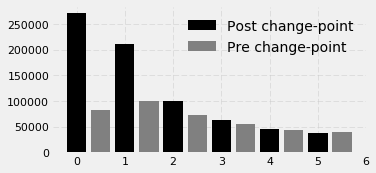

In [178]:
fig, ax = plt.subplots(1, 1, figsize=(5,2.5))
for i in range(6):
    if i == 0:
        ax.bar([i], [post_cp_bulge_dist[i]], color='k',
           width=0.4, label='Post change-point')
        ax.bar([i+0.5], [pre_cp_bulge_dist[i]], color='grey',
           width=0.4, label='Pre change-point')
    else:
        ax.bar([i], [post_cp_bulge_dist[i]], color='k', width=0.4)
        ax.bar([i+0.5], [pre_cp_bulge_dist[i]], color='grey', width=0.4)
#ax.set_yticks([x for x in range(0, 300000, 50000)])
ax.legend(frameon=False)
clean_axis(ax)
plt.savefig('../images/pre_post_cp_node_dist.svg', transparent=True, edgecolor='none')
plt.show()

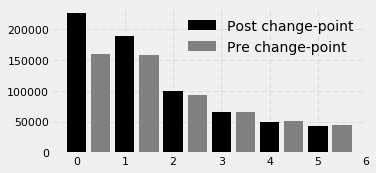

In [179]:
fig, ax = plt.subplots(1, 1, figsize=(5,2.5))
for i in range(6):
    if i == 0:
        ax.bar([i], [post_cp_bulge_dist_random[i]], color='k',
           width=0.4, label='Post change-point')
        ax.bar([i+0.5], [pre_cp_bulge_dist_random[i]], color='grey',
           width=0.4, label='Pre change-point')
    else:
        ax.bar([i], [post_cp_bulge_dist_random[i]], color='k', width=0.4)
        ax.bar([i+0.5], [pre_cp_bulge_dist_random[i]], color='grey', width=0.4)
#ax.set_yticks([x for x in range(0, 300000, 50000)])
ax.legend(frameon=False)
clean_axis(ax)
plt.savefig('../images/pre_post_cp_node_dist_random.svg', transparent=True, edgecolor='none')
plt.show()

In [181]:
for i in range(6):
    table = [
        [post_cp_bulge_dist[i], pre_cp_bulge_dist[i]],
        [post_cp_bulge_dist_random[i], pre_cp_bulge_dist_random[i]]
    ]
    print (table)
    print (fisher_exact(table))

[[270776, 82828], [226112, 160795]]
(2.3247803287969266, 0.0)
[[211552, 100190], [190132, 158357]]
(1.7586313385544892, 0.0)
[[99825, 72110], [99258, 92603]]
(1.2915266131162508, 1.0824978300381712e-320)
[[63538, 54364], [66222, 65626]]
(1.1582325818751504, 8.0346863722960665e-75)
[[45929, 43670], [50144, 51523]]
(1.0806522587058272, 2.6932480573657747e-17)
[[38278, 39100], [42427, 45135]]
(1.0414624198495421, 3.857417493777931e-05)


In [138]:
pvals = {x:[] for x in range(0, 6)}
odd_ratio = {x:[] for x in range(0, 6)}
for i in tqdm(range(1000)):
    rand_nums = [np.random.randint(len(change_point_positions)) for x in range(100)]
    n = 0
    pre_temp = {x:0 for x in range(0, 6)}
    post_temp = {x:0 for x in range(0, 6)}
    pre_rand = {x:0 for x in range(0, 6)}
    post_rand = {x:0 for x in range(0, 6)}
    
    for p,s in zip(change_point_positions, oq_sequences):
        if n in rand_nums:
            rand_pos = np.random.randint(min(change_point_positions),
                                         max(change_point_positions))
            sg_obj = StemGroups(s, max_loop_len=25, max_bulge_len=5, base='G')
            for sg in sg_obj.generate_stems():
                node_codes, sorted_nodes, G = populate_graph(sg)
                for node in sorted_nodes:
                    s1_len = node.count('-')
                    if node_codes[node][-1] < p:
                        pre_temp[s1_len] += 1
                    if 2*p > node_codes[node][0] >= p:
                        post_temp[s1_len] += 1
                    if node_codes[node][-1] < rand_pos:
                        pre_rand[s1_len] += 1
                    if 2*p > node_codes[node][0] >= rand_pos:
                        post_rand[s1_len] += 1  
        n+=1
    for i in range(6):
        table = [
            [pre_temp[i], post_temp[i]],
            [pre_rand[i], post_rand[i]],
        ]
        pvals[i].append(fisher_exact(table)[1])
        odd_ratio[i].append(fisher_exact(table)[0])

  6%|▋         | 64/1000 [01:25<20:55,  1.34s/it]


KeyboardInterrupt: 

1

In [139]:
pre_temp = {x:0 for x in range(0, 6)}
post_temp = {x:0 for x in range(0, 6)}
pre_rand = {x:0 for x in range(0, 6)}
post_rand = {x:0 for x in range(0, 6)}

def get_nodes(seq):
    from SNIPRQ import StemGroups
    import networkx as nx
    
    def stem_encoder(stem_array, graphStart):
        diff = np.diff(stem_array)
        if diff[0] != 1:
            return '%d%s**' % (stem_array[0] - graphStart, '-' * (diff[0] - 1))
        else:
            return '%d*%s*' % (stem_array[0] - graphStart, '-' * (diff[1] - 1))

    def populate_graph(stems):
        G = nx.DiGraph()
        maxLoopLen = 25
        graphStart = stems[0][0]
        all_starts = stems[:, 0]
        nodeCodes = {}
        sortedNodes = []
        for stem in stems:
            targets = np.where((all_starts > stem[2] + 1) &
                     (all_starts <= stem[2] + maxLoopLen + 1))[0]
            n1 = stem_encoder(stem, graphStart)
            sortedNodes.append(n1)
            nodeCodes[n1] = stem
            for t in targets:
                n2 = stem_encoder(stems[t], graphStart)
                l = stems[t][0] - stem[2] - 1
                G.add_edge(n1, n2, attr_dict={'length':l})
        return nodeCodes, sortedNodes, G
    
    sg_obj = StemGroups(s, max_loop_len=25, max_bulge_len=5, base='G')
    nc = []
    sn = []
    for sg in sg_obj.generate_stems():
        node_codes, sorted_nodes, G = populate_graph(sg)
        nc.append(node_codes)
        sn.append(sorted_nodes)
    return nc, sn

res = DVIEW.map(get_nodes, oq_sequences)


for p,s in tqdm(zip(change_point_positions, oq_sequences)):
    
    for sg in sg_obj.generate_stems():
        node_codes, sorted_nodes, G = populate_graph(sg)
        for node in sorted_nodes:
            s1_len = node.count('-')
            if node_codes[node][-1] < p:
                pre_temp[s1_len] += 1
            if 2*p > node_codes[node][0] >= p:
                post_temp[s1_len] += 1
            rand_pos = np.random.randint(min(change_point_positions),
                                         max(change_point_positions))
            if node_codes[node][-1] < rand_pos:
                pre_rand[s1_len] += 1
            if 2*p > node_codes[node][0] >= rand_pos:
                post_rand[s1_len] += 1
for i in range(6):
    table = [
        [pre_temp[i], post_temp[i]],
        [pre_rand[i], post_rand[i]],
    ]
    print (i, fisher_exact(table))

181it [00:36,  6.71it/s]


KeyboardInterrupt: 

In [137]:
for i in range(6):
    print (np.median(pvals[i]))

1.18743571545e-11
1.02219468853e-08
0.00262485521707
0.0649397004663
0.159979856696
0.21112572743


In [124]:
from scipy.stats import wilcoxon, ranksums, ttest_ind, fisher_exact

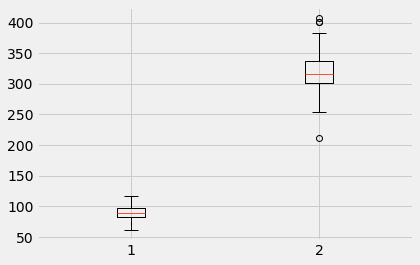

0 1.26166015849e-32


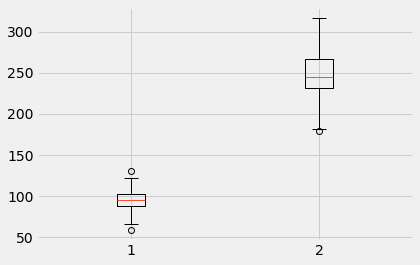

1 1.25761385932e-32


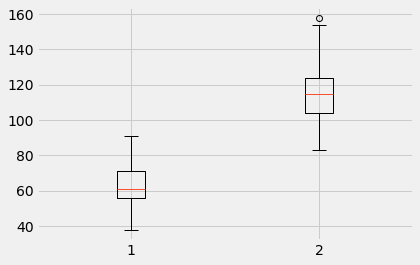

2 2.35713327654e-32


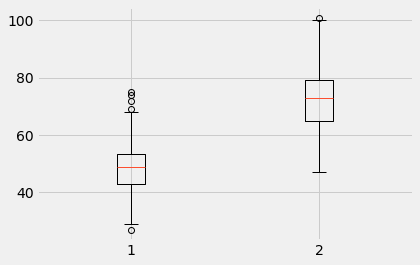

3 2.78647734487e-25


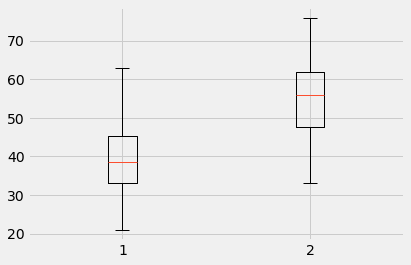

4 6.65670154037e-20


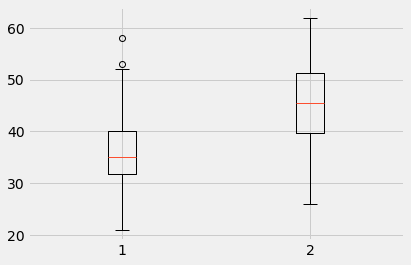

5 5.70166458375e-13


In [115]:
for i in range(6):
    p = mannwhitneyu(pre_dist[i], post_dist[i])[1]*100
    plt.boxplot([pre_dist[i], post_dist[i]])
    plt.show()
    print (i, p)

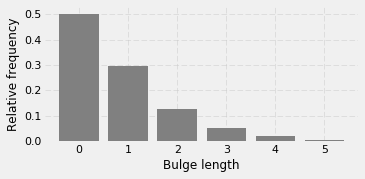

In [83]:
b1 = Counter(on_cp[:, 0])
v = np.array([b1[x] for x in range(6)])
v = v/v.sum()

fig, ax = plt.subplots(1, 1, figsize=(5, 2.3))
ax.bar(range(6), v, color='grey')
ax.set_xticks(range(6))
clean_axis(ax)
ax.set_xlabel('Bulge length', fontsize=12)
ax.set_ylabel('Relative frequency', fontsize=12)
plt.savefig('../images/oq_bulge_combined_dist.svg', transparent=True, edgecolor='none')
plt.show()

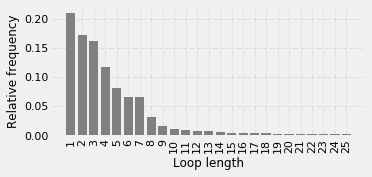

In [82]:
l = Counter(on_cp[:, 1])
v = np.array([l[x] for x in range(1,26)])
v = v/v.sum()

fig, ax = plt.subplots(1, 1, figsize=(5, 2.2))
ax.bar(range(25), v, color='grey')
ax.set_xticks(range(25))
ax.set_xticklabels(range(1,26), rotation=90)
ax.set_xlabel('Loop length', fontsize=12)
ax.set_ylabel('Relative frequency', fontsize=12)
clean_axis(ax)
plt.savefig('../images/oq_loops_combined_dist.svg', transparent=True, edgecolor='none')
plt.show()

0 0
0 1
0 2
0 3
0 4
0 5
1 1
1 2
1 3
1 4
1 5
2 2
2 3
2 4
2 5
3 3
3 4
3 5
4 4
4 5
5 5


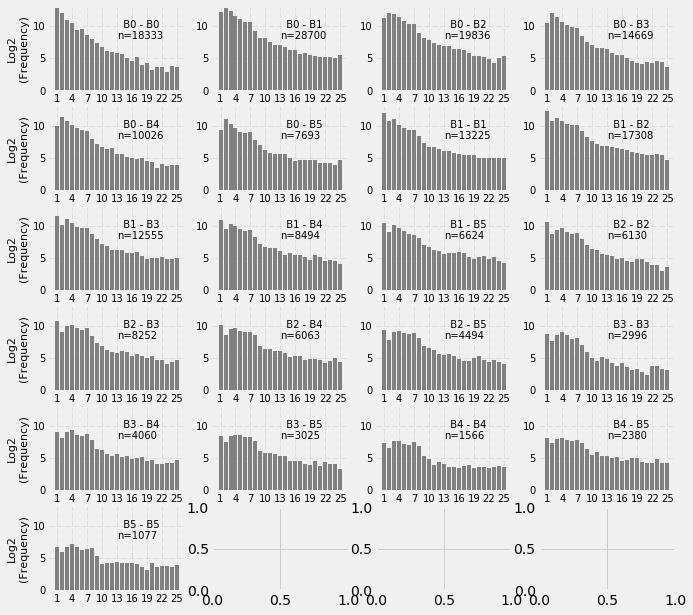

In [41]:
fig, axis = plt.subplots(6, 4, figsize=(10, 10))
row = 0
col = 0
for b1 in range(6):
    for b2 in range(6):
        if b1 > b2:
            continue
        print (b1, b2)
        ax = axis[row, col]
        a = Counter(on_cp[np.where((on_cp[:, 0] == b1) &
                                   (on_cp[:, 2] == b2))[0], 1])
        y = np.array([a[x] for x in range(1,26)])
        ax.bar(range(1,26), np.log2(y+1), color='grey')
        ax.text(13, 8, "  B%d - B%d\nn=%d" % (b1, b2, sum(y)), fontsize=10)
        if row == 6:
            ax.set_xlabel('Loop lengths', fontsize=11)
        if col == 0:
            ax.set_ylabel('Log2\n(Frequency)', fontsize=11)
        ax.set_xticks(range(1,26,3))
        ax.set_ylim((0, 13))
        clean_axis(ax)
        col +=1
        if col == 4:
            row += 1
            col = 0
plt.savefig('../images/oq_loop_dist_all.svg', transparent=True, edgecolor='none')
plt.show()

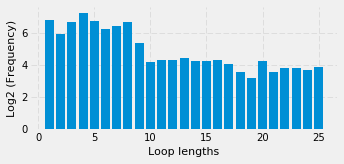

[111  61 102 151 106  74  84 100  41  17  19  19  21  18  18  19  16  11
   8  18  11  13  13  12  14]


In [13]:
fig, ax = plt.subplots(1, 1, figsize=(5,2.5))

a = Counter(on_cp[np.where((on_cp[:, 0] == 5) & (on_cp[:, 2] == 5))[0], 1])
y = np.array([a[x] for x in range(1,26)])

ax.bar(range(1,26), np.log2(y+1))
ax.set_xlabel('Loop lengths', fontsize=11)
ax.set_ylabel('Log2 (Frequency)', fontsize=11)

clean_axis(ax)

plt.tight_layout()
plt.savefig('../images/oq_loop_dist_5_5.svg', transparent=True, edgecolor='none')
plt.show()
print (y)

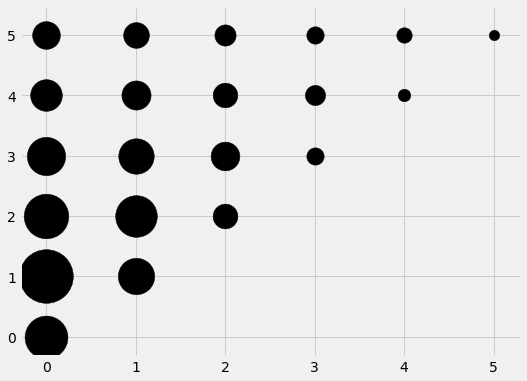

[[18333, 28700, 19836, 14669, 10026, 7693],
 [13225, 17308, 12555, 8494, 6624],
 [6130, 8252, 6063, 4494],
 [2996, 4060, 3025],
 [1566, 2380],
 [1077]]

In [11]:
total_loops = [[] for x in range(6)]
for i in combinations_with_replacement(range(0,6), 2):
    a = len(np.where((on_cp[:, 0] == i[0]) & (on_cp[:, 2] == i[1]))[0])
    total_loops[i[0]].append(a)
    
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for i in range(6):
    for j in range(len(total_loops[i])):
        ax.scatter([i], [j+i], s=total_loops[i][j]/10, c='k')
plt.savefig('../images/oq_bulge_on_cp_scatter.svg',
            transparent=True, edgecolor='none')
plt.show()
total_loops

In [536]:
for i in combinations_with_replacement(range(6), 2):
    for j in range(1,26):
        a = len(on_cp[np.where((on_cp[:, 0] == i[0]) &
                     (on_cp[:, 2] == i[1]) &
                     (on_cp[:, 1] == j))[0]])
        print (i[0], j, i[1], a)

0 1 0 7665
0 2 0 4230
0 3 0 2048
0 4 0 1516
0 5 0 716
0 6 0 808
0 7 0 412
0 8 0 247
0 9 0 160
0 10 0 107
0 11 0 71
0 12 0 60
0 13 0 55
0 14 0 51
0 15 0 34
0 16 0 24
0 17 0 36
0 18 0 14
0 19 0 19
0 20 0 8
0 21 0 11
0 22 0 11
0 23 0 6
0 24 0 13
0 25 0 11
0 1 1 4712
0 2 1 7451
0 3 1 5548
0 4 1 3180
0 5 1 2288
0 6 1 1647
0 7 1 1571
0 8 1 606
0 9 1 298
0 10 1 280
0 11 1 193
0 12 1 132
0 13 1 140
0 14 1 113
0 15 1 80
0 16 1 74
0 17 1 52
0 18 1 59
0 19 1 47
0 20 1 40
0 21 1 36
0 22 1 37
0 23 1 38
0 24 1 32
0 25 1 46
0 1 2 2416
0 2 2 4248
0 3 2 4019
0 4 2 2691
0 5 2 1768
0 6 2 1295
0 7 2 1309
0 8 2 496
0 9 2 287
0 10 2 223
0 11 2 162
0 12 2 137
0 13 2 126
0 14 2 117
0 15 2 87
0 16 2 85
0 17 2 77
0 18 2 58
0 19 2 41
0 20 2 40
0 21 2 35
0 22 2 29
0 23 2 18
0 24 2 33
0 25 2 39
0 1 3 1488
0 2 3 4405
0 3 3 2751
0 4 3 1645
0 5 3 1233
0 6 3 982
0 7 3 883
0 8 3 345
0 9 3 196
0 10 3 128
0 11 3 98
0 12 3 100
0 13 3 85
0 14 3 59
0 15 3 45
0 16 3 43
0 17 3 31
0 18 3 23
0 19 3 18
0 20 3 17
0 21 3 20
0 22 3

In [431]:
table = np.array([
    [[1], [], [], [], [], []],
    [[], [], [], [], [], []],
    [[], [], [], [], [], []],
    [[], [], [], [], [], []],
    [[], [], [], [], [], []],
    [[], [], [], [], [], []],
])
table_sums = np.zeros(shape=(6,6), dtype=int)

for i in combinations_with_replacement(range(6), 2):
    vals = []
    for j in range(1,26):
        a = len(on_cp[np.where((on_cp[:, 0] == i[0]) &
                     (on_cp[:, 2] == i[1]) &
                     (on_cp[:, 1] == j))[0]])
        #print (i[0], j, i[1], a)
        vals.append(a)
    table[i[0], i[1]] = vals
    table[i[1], i[0]] = vals
    table_sums[i[0], i[1]] = sum(vals)
    table_sums[i[1], i[0]] = sum(vals)

In [435]:
table_sums

array([[13768, 11745,  7713,  6588,  4565,  3807],
       [11745,  5970,  6872,  4574,  3151,  2466],
       [ 7713,  6872,  2301,  2637,  2091,  1456],
       [ 6588,  4574,  2637,   833,  1270,   912],
       [ 4565,  3151,  2091,  1270,   526,   894],
       [ 3807,  2466,  1456,   912,   894,   448]])

In [441]:
table_sums.sum(axis=1)[0]

48186

array([48186, 34778, 23070, 16814, 12497,  9983])

In [433]:
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(100, 100)

In [ ]:
for i in range(6):
    r = 100*(table_sums[i, j]/table_sums.sum(axis=1)[0])
    for j in range(6):
        
        ax = plt.subplot(gs[:r, :r])